## <hr><center>Task 4</center><hr>

Consider the dataset of time series CityGlobalTemperature2000-2009.csv containing for 100 cities the temperature measurements (mean and standard deviation over a month). The goal of the task is to find groups of similar cities with respect to the temperature trends.

In [ ]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import Library

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
# Load the temperature dataframe.
 
temp_df = pd.read_csv('data/CityGlobalTemperature2000-2009.csv')
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     12000 non-null  int64  
 1   AverageTemperature             12000 non-null  float64
 2   AverageTemperatureUncertainty  12000 non-null  float64
 3   City                           12000 non-null  object 
 4   Country                        12000 non-null  object 
 5   Latitude                       12000 non-null  object 
 6   Longitude                      12000 non-null  object 
 7   time                           12000 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 750.1+ KB


In [ ]:
# Reshape the time series into (N_time_series, N_years*12, 1).
# Group by city and concat into single time-series.

cities = temp_df.groupby('City')['Latitude','Longitude'].first().reset_index()

cities_temp_df      = temp_df.groupby('City')['AverageTemperature'].apply(list)
cities_temp_time_df = temp_df.groupby('City')['time'].apply(list)
cities_temp_unc_df  = temp_df.groupby('City')['AverageTemperatureUncertainty'].apply(list)

cities_temp = cities_temp_df.to_numpy()
cities_temp = np.stack(cities_temp, axis=0)

cities_temp_unc = cities_temp_unc_df.to_numpy()
cities_temp_unc = np.stack(cities_temp_unc, axis=0)

cities_temp_time = cities_temp_time_df.to_numpy()
cities_temp_time = np.stack(cities_temp_time, axis=0)

cities_temp.shape, cities_temp_unc.shape, cities_temp_time.shape

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


((100, 120), (100, 120), (100, 120))

--- Euclidean ---


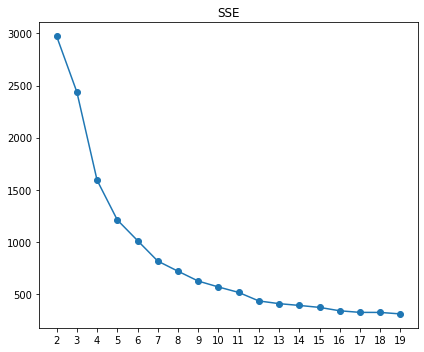

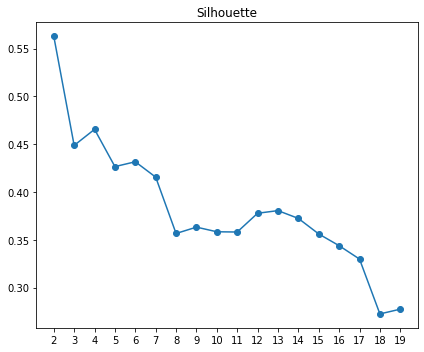

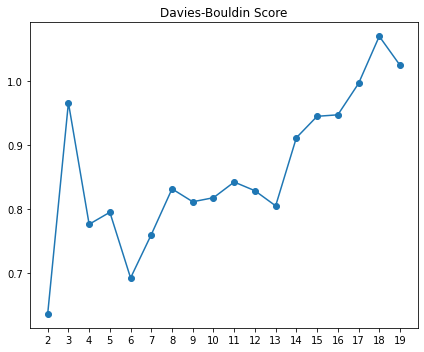

--- DTW ---


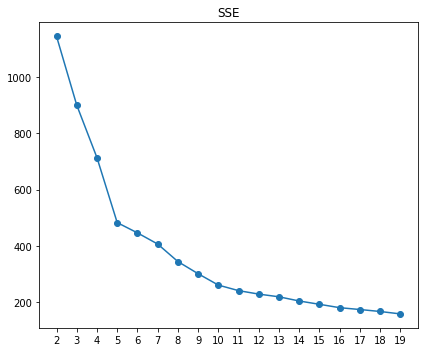

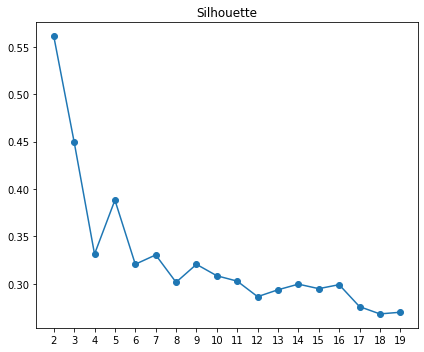

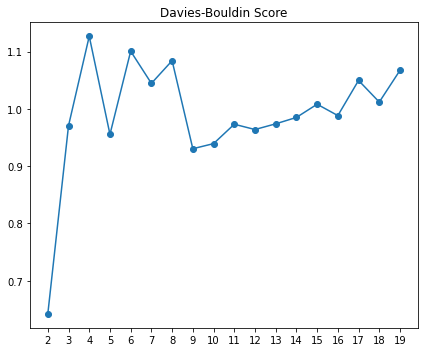

In [ ]:
# Use the elbow method to determine the optimal number of clusters for k-means.
# This method is generalized over the metric used for clustering, so that Euclidean and DTW can be tried.

def plot_elbow(df, kmeans_range, metric):
    sse, sil, dbs = [], [], []
    for k in kmeans_range:
        kmeans = TimeSeriesKMeans(n_clusters=k, metric=metric, max_iter=10, random_state=0).fit(df)
        sse.append(kmeans.inertia_)
        sil.append(silhouette_score(df, kmeans.labels_))
        dbs.append(davies_bouldin_score(df, kmeans.labels_))

    plt.title('SSE')
    plt.gcf().set_size_inches(6, 5)
    plt.plot(list(map(str, list(kmeans_range))), sse, marker='o')
    Library.save(f'kmeans_{metric}_SSE.svg')
    plt.show()
    
    plt.title('Silhouette')
    plt.gcf().set_size_inches(6, 5)
    plt.plot(list(map(str, list(kmeans_range))), sil, marker='o')
    Library.save(f'kmeans_{metric}_Silhouette.svg')
    plt.show()
    
    plt.title('Davies-Bouldin Score')
    plt.gcf().set_size_inches(6, 5)
    plt.plot(list(map(str, list(kmeans_range))), dbs, marker='o')
    Library.save(f'kmeans_{metric}_Davies.svg')
    plt.show()

print('--- Euclidean ---')
plot_elbow(cities_temp, range(2, 20), 'euclidean')

print('--- DTW ---')
plot_elbow(cities_temp, range(2, 20), 'dtw')

In [ ]:
# List of colors
colors5 = list(map(matplotlib.colors.to_hex, ['limegreen', 'red', 'royalblue', 'darkorange', 'orchid']))
colors6 = list(map(matplotlib.colors.to_hex, ['limegreen', 'red', 'royalblue', 'darkorange', 'orchid', 'black']))

# Number of clusters selected for classification by inspecting the elbow graph.
n_clusters_euclidean = 6
n_clusters_dtw = 5

# Re-cluster the data using the selected number of clusters.
kmeans_euc = TimeSeriesKMeans(n_clusters=n_clusters_euclidean, metric="euclidean", max_iter=10, random_state=0)
kmeans_euc.fit(cities_temp)

kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters_dtw, metric="dtw", max_iter=10, random_state=0)
kmeans_dtw.fit(cities_temp)

# Display the clustering scores.
print('Silhouette')
print('Euclidean =', silhouette_score(cities_temp, kmeans_euc.labels_))
print('DTW       =', silhouette_score(cities_temp, kmeans_dtw.labels_))

print('\nSSE')
print('Euclidean =', kmeans_euc.inertia_)
print('DTW       =', kmeans_dtw.inertia_)

Silhouette
Euclidean = 0.43163499289427953
DTW       = 0.3882569665754464

SSE
Euclidean = 1012.4428926799276
DTW       = 483.00006696354694


In [ ]:
# Assign the cluster labels to the dataframe.

cities['AverageYearTemperature'] = np.average(cities_temp,axis=1)

cities['KMeansEuclideanLabel'] = kmeans_euc.labels_
cities['KMeansDTWLabel']       = kmeans_dtw.labels_

# Assign the correct colors for visualization.
cities['KMeansEuclideanLabelColor'] = cities['KMeansEuclideanLabel'].apply(lambda i: colors6[i])
cities['KMeansDTWLabelColor']       = cities['KMeansDTWLabel']      .apply(lambda i: colors5[i])

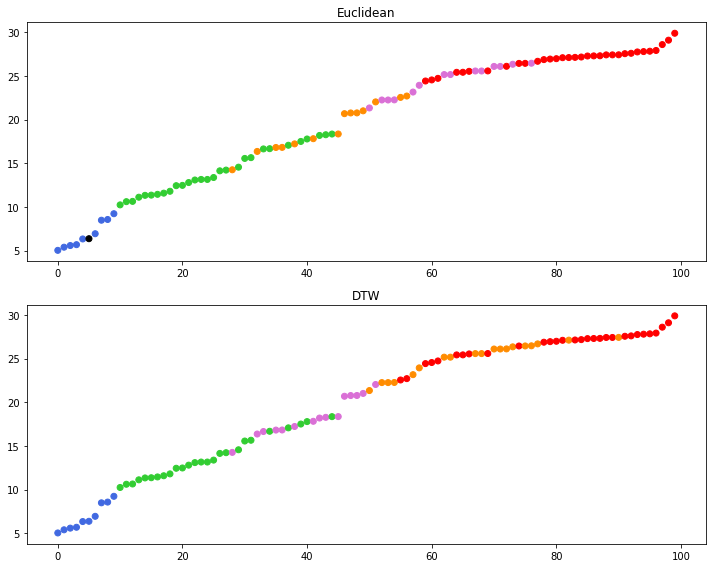

In [ ]:
# Compute the avg for each city, then we scatter plot with color=cluster, x=city, y=avg temp.
# The scatter plot is ordered in terms of average year temperature.

cities_sorted = cities.sort_values('AverageYearTemperature')

plt.gcf().set_size_inches(10, 8)
plt.subplot(2, 1, 1)
plt.title('Euclidean')
plt.scatter(x=range(cities_sorted.shape[0]), y=cities_sorted['AverageYearTemperature'], c=cities_sorted['KMeansEuclideanLabelColor'])
plt.subplot(2, 1, 2)
plt.title('DTW')
plt.scatter(x=range(cities_sorted.shape[0]), y=cities_sorted['AverageYearTemperature'], c=cities_sorted['KMeansDTWLabelColor'])
Library.save('average_temperature.svg')

In [11]:
# Plot the scatter results on the world map.
# On some notebook viewers the kaleido package is required to properly visualize the maps.
def plot_world_map(df, label, filename, colors=colors5):
    
    # Convert the latitude and longitude of the dataset to the correct format.
    def convert(s):
        return '-' + s[:-1] if s[-1] == 'W' or s[-1] == 'S' else s[:-1]

    fig = px.scatter_geo(df,
        lat=df['Latitude'].apply(convert),
        lon=df['Longitude'].apply(convert) ,
        hover_name="City",
        color=np.array(list(map(repr,df[label]))),
        color_discrete_map={repr(i): c for i, c in enumerate(colors)})
    fig.update_layout(showlegend=False, margin_l=0, margin_r=0, margin_b=0, margin_t=0)
    fig.show()
    fig.write_image(f'{filename}_worldmap.svg')

# Visualize the two euclidean and DTW world maps.
print("KMeans - Euclidean")
plot_world_map(cities, 'KMeansEuclideanLabel', 'kmeans_euclidean', colors=colors6)
print("KMeans - DTW")
plot_world_map(cities, 'KMeansDTWLabel', 'kmeans_dtw', colors=colors5)

KMeans - Euclidean


KMeans - DTW


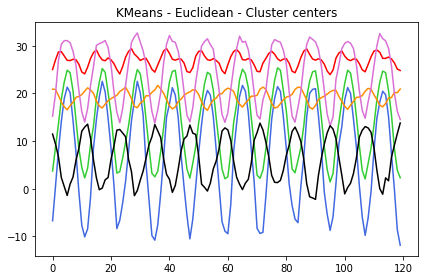

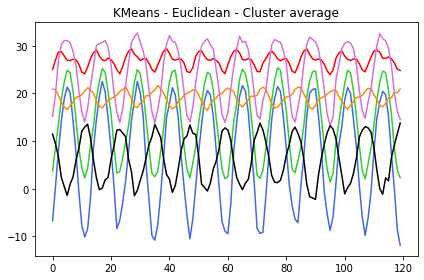

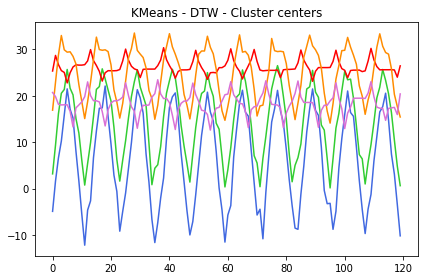

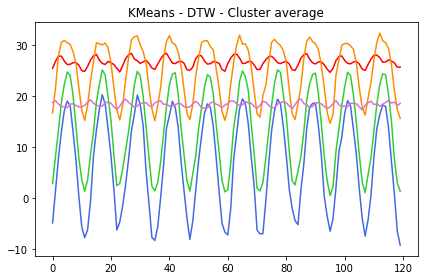

In [ ]:
# Plot the mean time series in each cluster by considering the mean temperature for all sequences inside of the cluster.

def plot_cluster_centers(df, kmeans, n_clusters, colors, filename, title):
    plt.title(title + ' - Cluster centers')
    for i in range(n_clusters):
        plt.plot(kmeans.cluster_centers_[i], color=colors[i])
    Library.save(f'{filename}_cluster_centers.svg')
    plt.show()

    plt.title(title + ' - Cluster average')
    for i in range(n_clusters):
        plt.plot(np.mean(df[kmeans.labels_ == i], axis=0), color=colors[i])
    Library.save(f'{filename}_cluster_average.svg')
    plt.show()

# Plot both Euclidean and DTW cluster centers and averages.

plot_cluster_centers(cities_temp, kmeans_euc, n_clusters_euclidean, colors=colors6, filename='euclidean',  title='KMeans - Euclidean')
plot_cluster_centers(cities_temp, kmeans_dtw, n_clusters_dtw,       colors=colors5, filename='dtw',        title='KMeans - DTW')

# Hierarchical clustering

In [ ]:
# Apply hierarchical clustering, again generalized on the metric.
# For this case, we only consider the euclidean metric.
# This follows essentially the same steps as standard hierarchical clustering.
 
def hierarchical_clustering_process(distances, method, metric, height):
    print(f'Hierarchical {method} {metric}')
    plt.gcf().set_size_inches(14, 7)
    data_link = linkage(distances, method=method, metric=metric)
    dendrogram(data_link, truncate_mode='lastp', color_threshold=height)
    plt.axhline(y=height, color="black")
    plt.gcf().set_size_inches(14, 10)
    Library.save(f'{method}_dendogram.svg')
    plt.show()
    return cut_tree(data_link, height=height)

def characterize_clusters(df, cluster_labels, label, method):
    df[label] = cluster_labels
    Library.reorder_clusters(df, label)
    print(df[label].value_counts())
    df[label].value_counts().plot(kind='bar'),  
    plt.gcf().set_size_inches(6, 4)
    Library.save(f'{method}_cluster.svg')  
    plt.show()

def hierarchical_process(method, height):
    distances = pdist(cities_temp, metric='euclidean')
    
    result = hierarchical_clustering_process(distances=distances, method=method, height=height, metric='euclidean')
    characterize_clusters(cities, cluster_labels=result, label=method + 'Label', method=method)
    print("Silhoutte =",silhouette_score(cities_temp, cities[method + 'Label']))

Hierarchical single euclidean


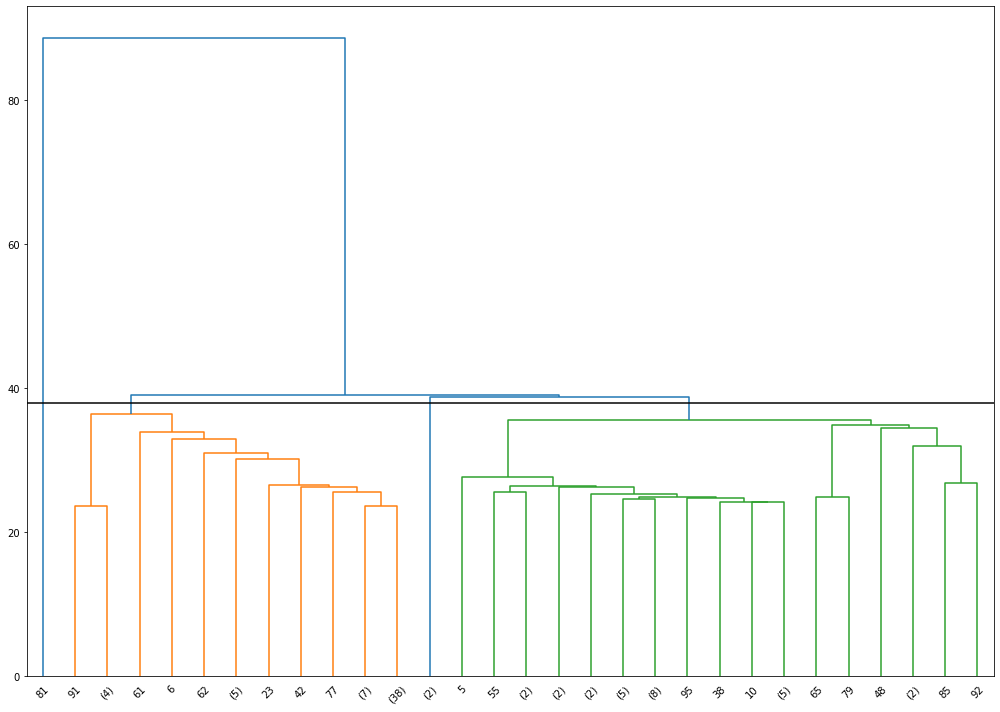

0    61
1    36
2     2
3     1
Name: singleLabel, dtype: int64


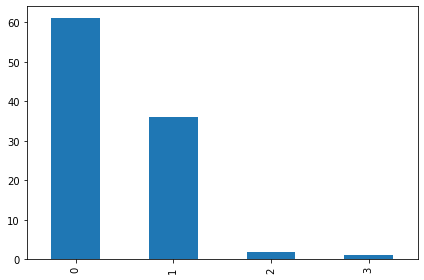

Silhoutte = 0.4118819797323527


In [ ]:
hierarchical_process('single', 38, show_boxplots=False)
plot_world_map(cities, 'singleLabel', 'single')

Hierarchical complete euclidean


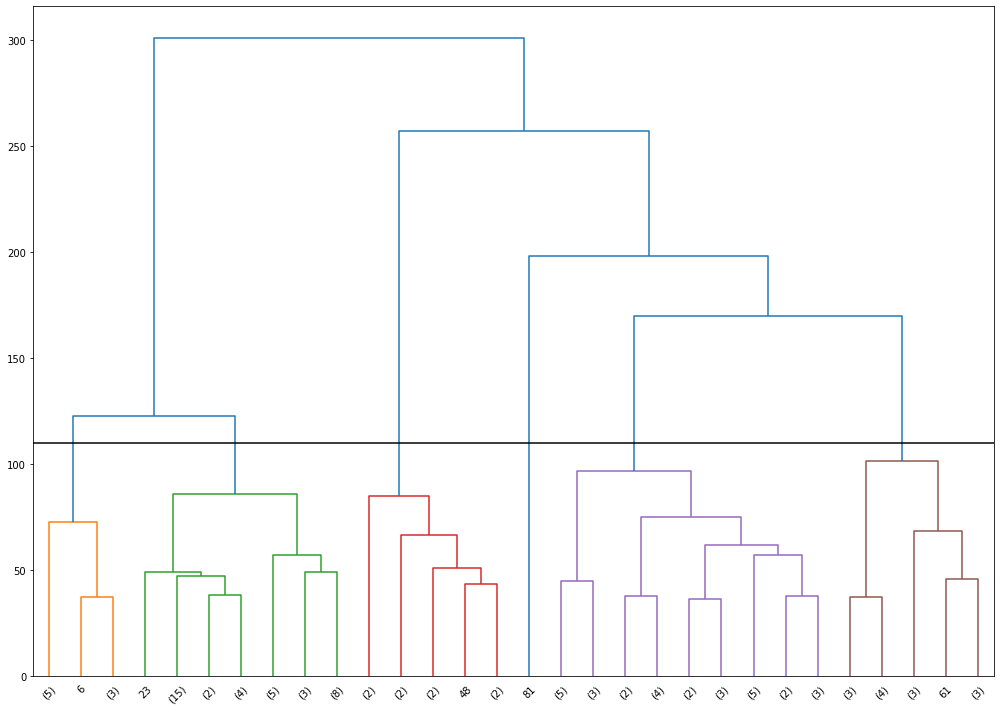

0    38
1    29
2    14
3     9
4     9
5     1
Name: completeLabel, dtype: int64


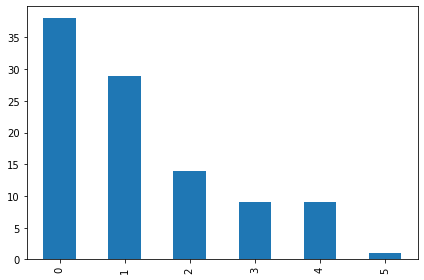

Silhoutte = 0.39979682602759836


In [ ]:
hierarchical_process('complete', 110, show_boxplots=False)
plot_world_map(cities, 'completeLabel', 'complete')

Hierarchical average euclidean


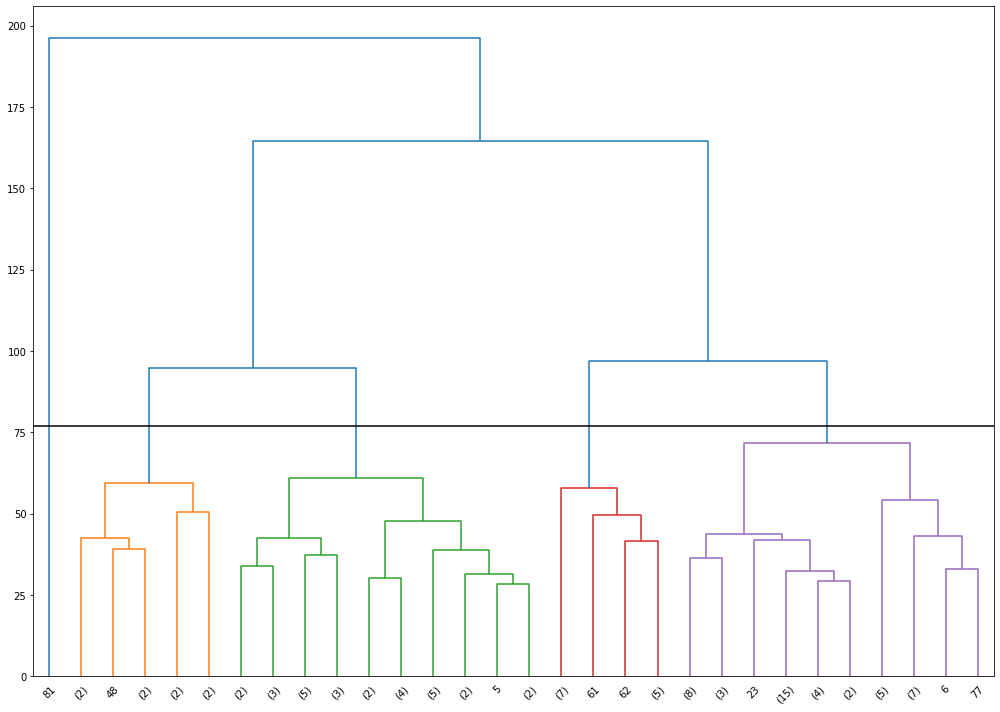

0    47
1    29
2    14
3     9
4     1
Name: averageLabel, dtype: int64


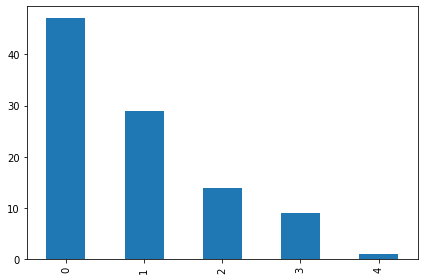

Silhoutte = 0.4401044235361071


In [ ]:
hierarchical_process('average', 77, show_boxplots=False)
plot_world_map(cities, 'averageLabel', 'average')

Hierarchical ward euclidean


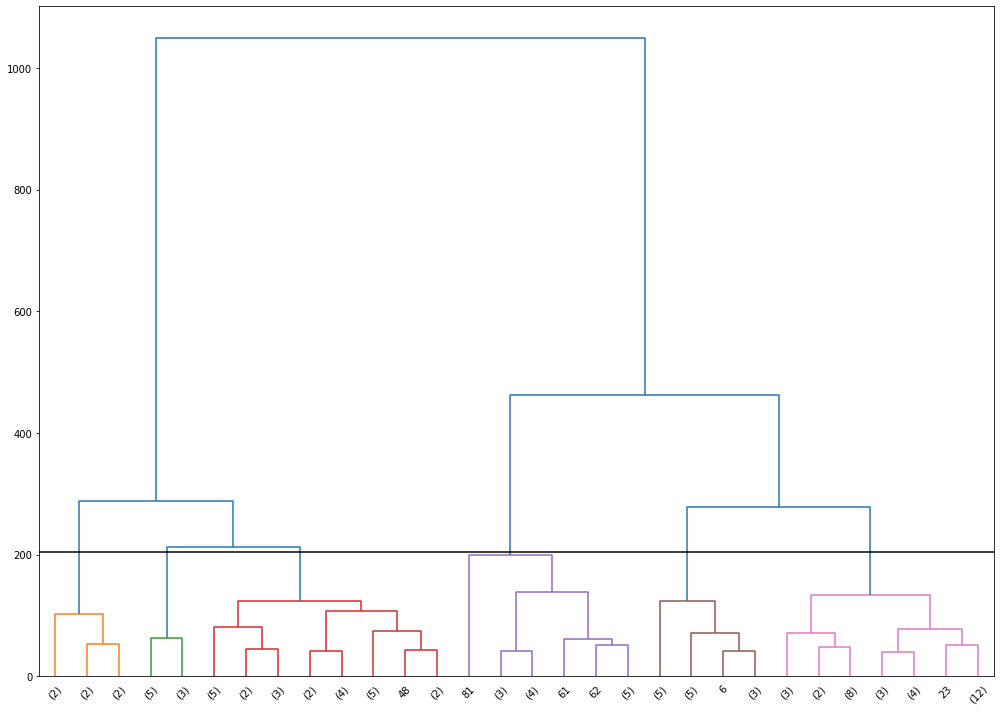

0    33
1    24
2    15
3    14
4     8
5     6
Name: wardLabel, dtype: int64


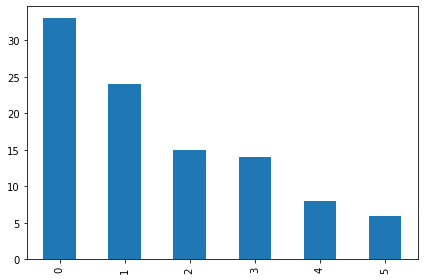

Silhoutte = 0.38756687147991536


In [ ]:
hierarchical_process('ward', 205, show_boxplots=False)
plot_world_map(cities, 'wardLabel', 'ward')

# Feature based clustering

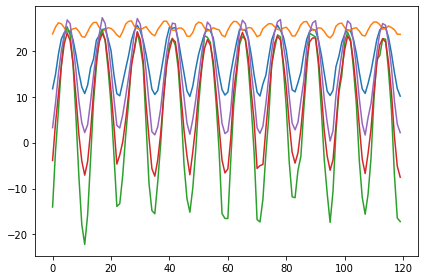

SSE =  30938.061242371765
Sil = 0.2029642774934021


In [ ]:
# Use the statistical values (features) of the time series and then apply KMeans.

def calculate_features(values):
    return {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

features = [list(calculate_features(x).values()) for x in cities_temp]

# Apply KMeans to the dataset with the same cluster size to produce comparable results.

kmeans = KMeans(n_clusters=5)
kmeans.fit(features)

# Compute the cluster average and the clustering scores obtained.

for i in range(5):
    plt.plot(np.mean(cities_temp[np.where(kmeans.labels_ == i)[0]], axis=0))
Library.save('feature_cluster_average.svg')
plt.show()

print('SSE = ', kmeans.inertia_)
print('Sil =', silhouette_score(cities_temp, kmeans.labels_))

cities['featureLabel'] = kmeans.labels_
plot_world_map(cities, 'featureLabel', 'feature')

# KMeans on reduced time series

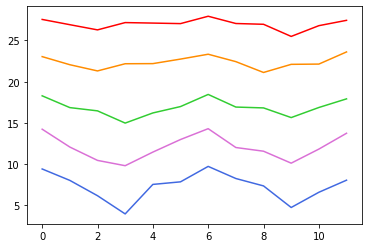

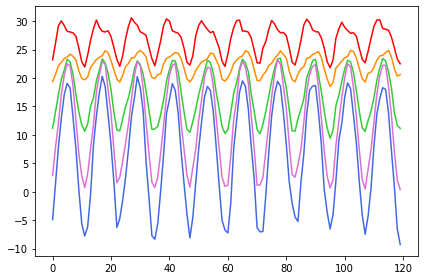

SSE =  14.935454601502014
Sil = 0.29019474938225664


In [ ]:
# Experiment by reducing the dimensionality of the time series and considering the average over months.
 
# DTW is applied with KMeans on the reduced dimensionality.
cities_temp_per_month = np.mean(cities_temp.reshape(cities_temp.shape[:-1] + (12,10)), axis=2)
tskm = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10, random_state=0)
tskm.fit(cities_temp_per_month)

# Compute the cluster average and the clustering scores obtained.

for i in range(5):
    plt.plot(tskm.cluster_centers_[i], color=colors5[i])
plt.show()

for i in range(5):
    plt.plot(np.mean(cities_temp[tskm.labels_ == i], axis=0), color=colors5[i])
Library.save('reduced_cluster_average.svg')
plt.show()

print('SSE = ', tskm.inertia_)
print('Sil =', silhouette_score(cities_temp, tskm.labels_))

cities['reducedLabel'] = tskm.labels_
plot_world_map(cities, 'reducedLabel', 'reduced')